In [15]:
import numpy as np
import matplotlib.pyplot as plt
from useful_functions import *
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Load data

# Preprocessing

In [111]:
#indy_20160407_02_py
#loco_20170210_03_py
data = get_clean_data('loco_20170210_03_py.mat')
data.keys()

dict_keys(['spM', 'evM', 'handM', 'cursorM', 't', 'targetM'])

### resample to get instantaneous firing rate

Original shape: (174, 204445)
Resampled shape: (174, 4089)


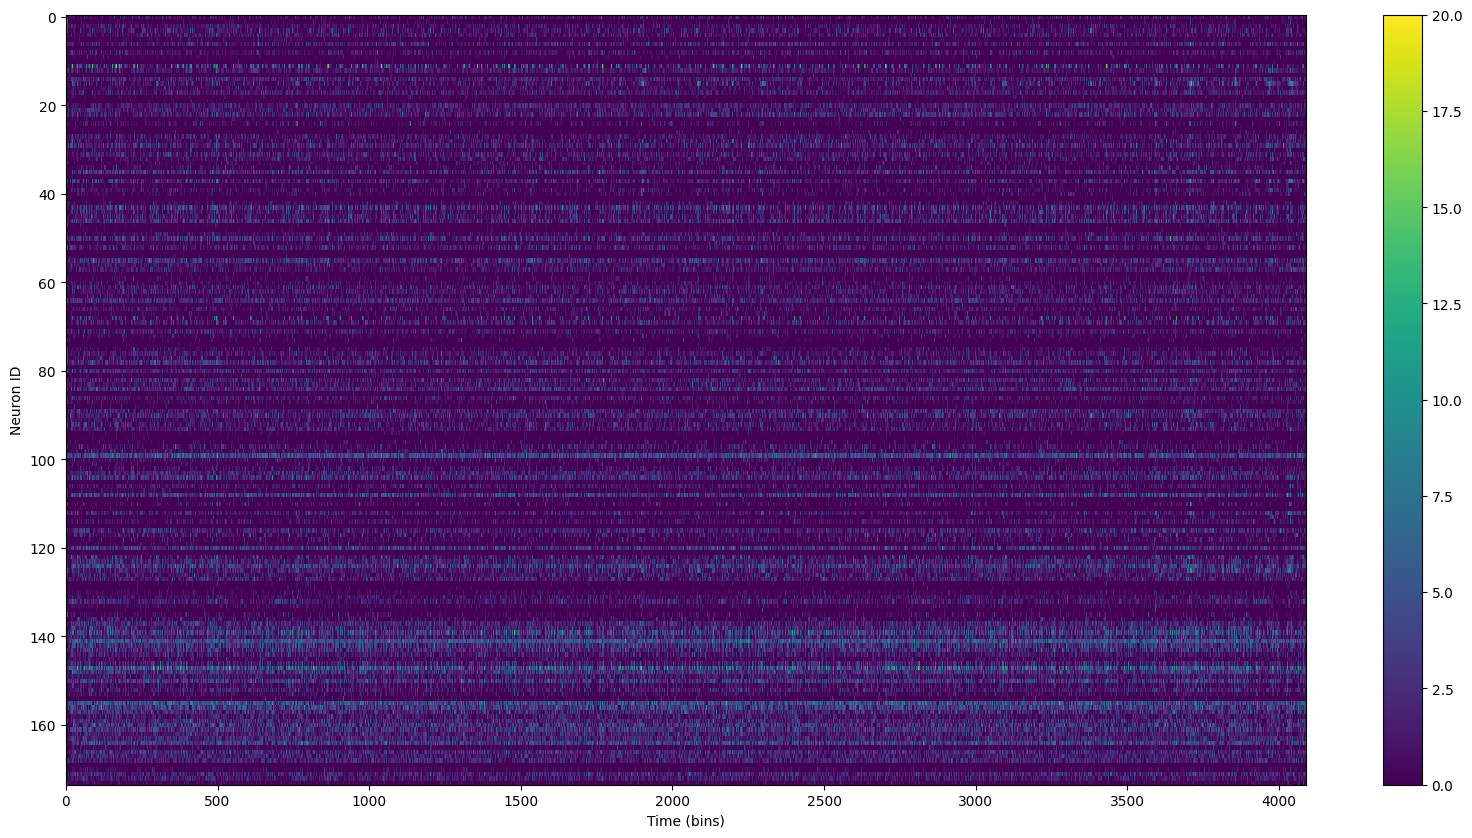

In [112]:
time_bins = data['t']

new_bin_size = 200*10**-3  # s

# Calculate the ratio between the new and old bin sizes
resample_factor = int(new_bin_size / np.mean(np.diff(time_bins)))  

# Resample the matrix by summing the spikes within each new bin
# Use np.add.reduceat to sum spikes within each group of 'resample_factor' bins
r_spM = np.add.reduceat(data['spM'], np.arange(0, data['spM'].shape[1], resample_factor), axis=1)

print("Original shape:", data['spM'].shape)
print("Resampled shape:", r_spM.shape)

plt.figure(figsize=(20, 10))
plt.imshow(r_spM, aspect='auto', interpolation='nearest')
plt.xlabel('Time (bins)')
plt.ylabel('Neuron ID')
plt.colorbar()

### create labels

In [113]:
target_x = data['targetM'][0].flatten()
target_y = data['targetM'][1].flatten()

r_target_x = np.add.reduceat(target_x, np.arange(0, target_x.size, resample_factor),)/resample_factor
r_target_y = np.add.reduceat(target_y, np.arange(0, target_y.size, resample_factor),)/resample_factor

mx = np.mean(r_target_x)
my = np.mean(r_target_y)
r_target_x = r_target_x - mx
r_target_y = r_target_y - my

four_dim_labels = np.zeros_like(r_target_x)
up_down_labels = np.zeros_like(r_target_x)
left_right_labels = np.zeros_like(r_target_x)
for i in range(r_target_x.size):
    four_dim_labels[i] = 0 if r_target_x[i] > 0 and r_target_y[i] > 0 else 1 if r_target_x[i] > 0 and r_target_y[i] < 0 else 2 if r_target_x[i] < 0 and r_target_y[i] < 0 else 3
    #only up and down
    up_down_labels[i] = 0 if r_target_y[i] > 0 else 1
    #only left and right
    left_right_labels[i] = 0 if r_target_x[i] > 0 else 1

np.savetxt('groups.csv', four_dim_labels, delimiter=',')

### create linear SVM classifier to evaluate the separability of the classes

In [105]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(r_spM.T, four_dim_labels, test_size=0.2, random_state=42)

# Train a linear SVM classifier
svm = SVC()
svm.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.589242053789731


In [106]:
order = 2
expanded_spM = expand_state_space(r_spM, order)
lda = LinearDiscriminantAnalysis(n_components=3)
X = lda.fit_transform(expanded_spM.T, four_dim_labels)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(r_spM.T, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracyND = np.mean(y_pred == y_test)
print("Accuracy in the N dimension manifold:", accuracyND)

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy3D = np.mean(y_pred == y_test)
print("Accuracy in the 3D manifold:", accuracy3D)




# # Texte à ajouter
# lignes_a_ajouter = ','.join([str(int(new_bin_size*1000)), str(round(accuracyND, 2)), str(round(accuracy3D, 2))]) + '\n'

# # Ouvrir le fichier en mode 'append' (ajout)
# with open("results.txt", 'a') as f:
#     f.write(lignes_a_ajouter)
# res = np.loadtxt("results.txt", dtype=str, delimiter=",")[1:].astype(float)
# bins = res[:,0]
# nd = res[:,1]
# D3 = res[:,2]

# plt.scatter(bins, nd, label='N dimensions')
# plt.scatter(bins, D3, label='3 dimensions')
# plt.xlabel('bin size (ms)')
# plt.ylabel('Accuracy')
# plt.legend()

Accuracy in the N dimension manifold: 0.589242053789731
Accuracy in the 3D manifold: 0.9266503667481663
